This code was made with the help of ChatGPT

In [7]:
import pandas as pd

# Load the dataset
file_path = "GiveMeSomeCredit-training.csv"
df = pd.read_csv(file_path)

# Fill missing values using forward fill, then backward fill as a fallback
df_filled = df.fillna(method='ffill').fillna(method='bfill')

# Check for remaining missing values
missing_values = df_filled.isnull().sum()

missing_values


/tmp/ipykernel_1094/2820278721.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df.fillna(method='ffill').fillna(method='bfill')


Unnamed: 0                              0
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

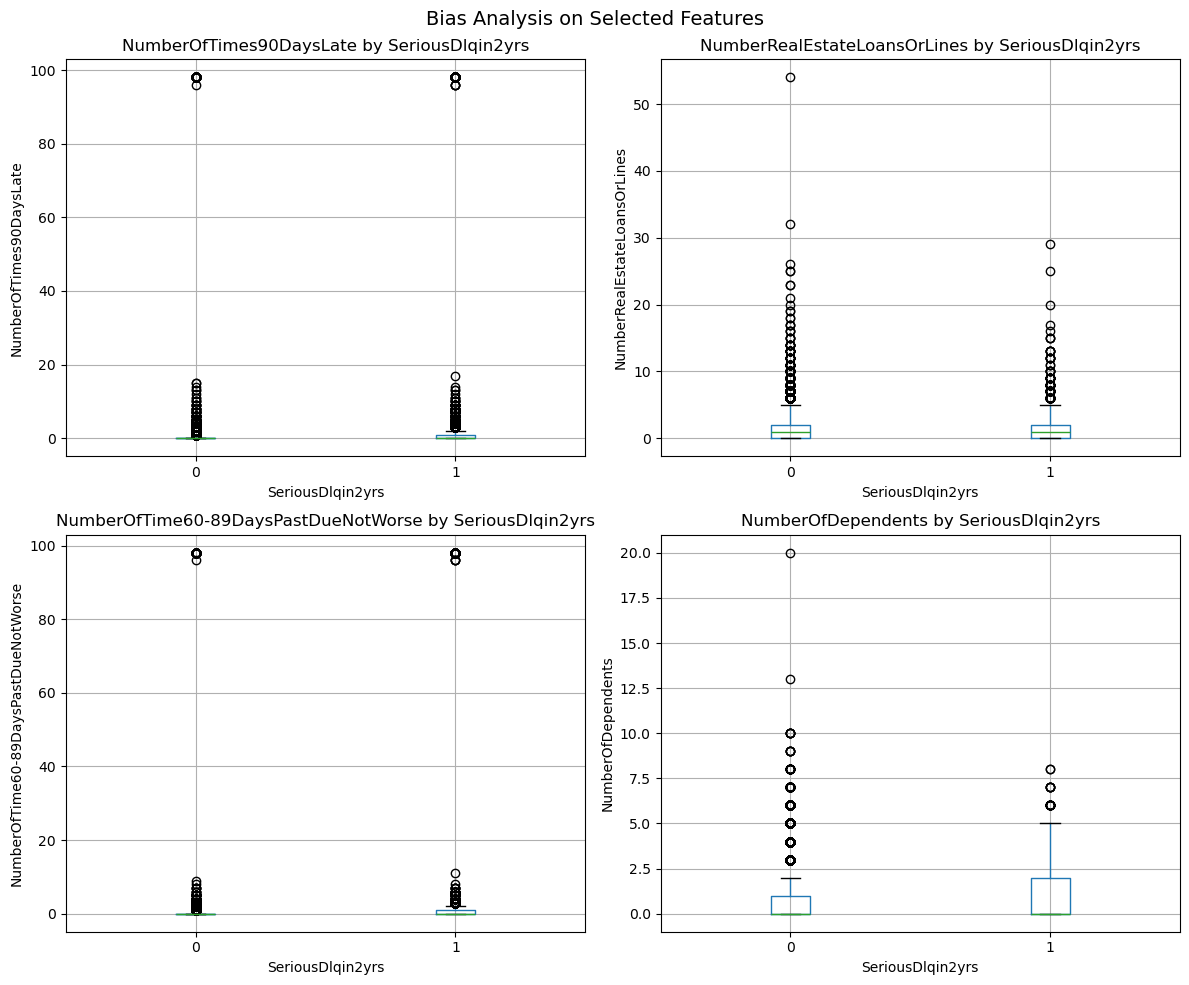

In [9]:
import matplotlib.pyplot as plt

# Define the target variable and features of interest
target_variable = "SeriousDlqin2yrs"
features_of_interest = [
    "NumberOfTimes90DaysLate",
    "NumberRealEstateLoansOrLines",
    "NumberOfTime60-89DaysPastDueNotWorse",
    "NumberOfDependents",
]

# Analyze potential biases by comparing distributions across target variable classes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.flatten()

for i, feature in enumerate(features_of_interest):
    df_filled.boxplot(column=feature, by=target_variable, ax=axes[i])
    axes[i].set_title(f"{feature} by {target_variable}")
    axes[i].set_xlabel(target_variable)
    axes[i].set_ylabel(feature)

plt.suptitle("Bias Analysis on Selected Features", fontsize=14)
plt.tight_layout()
plt.show()


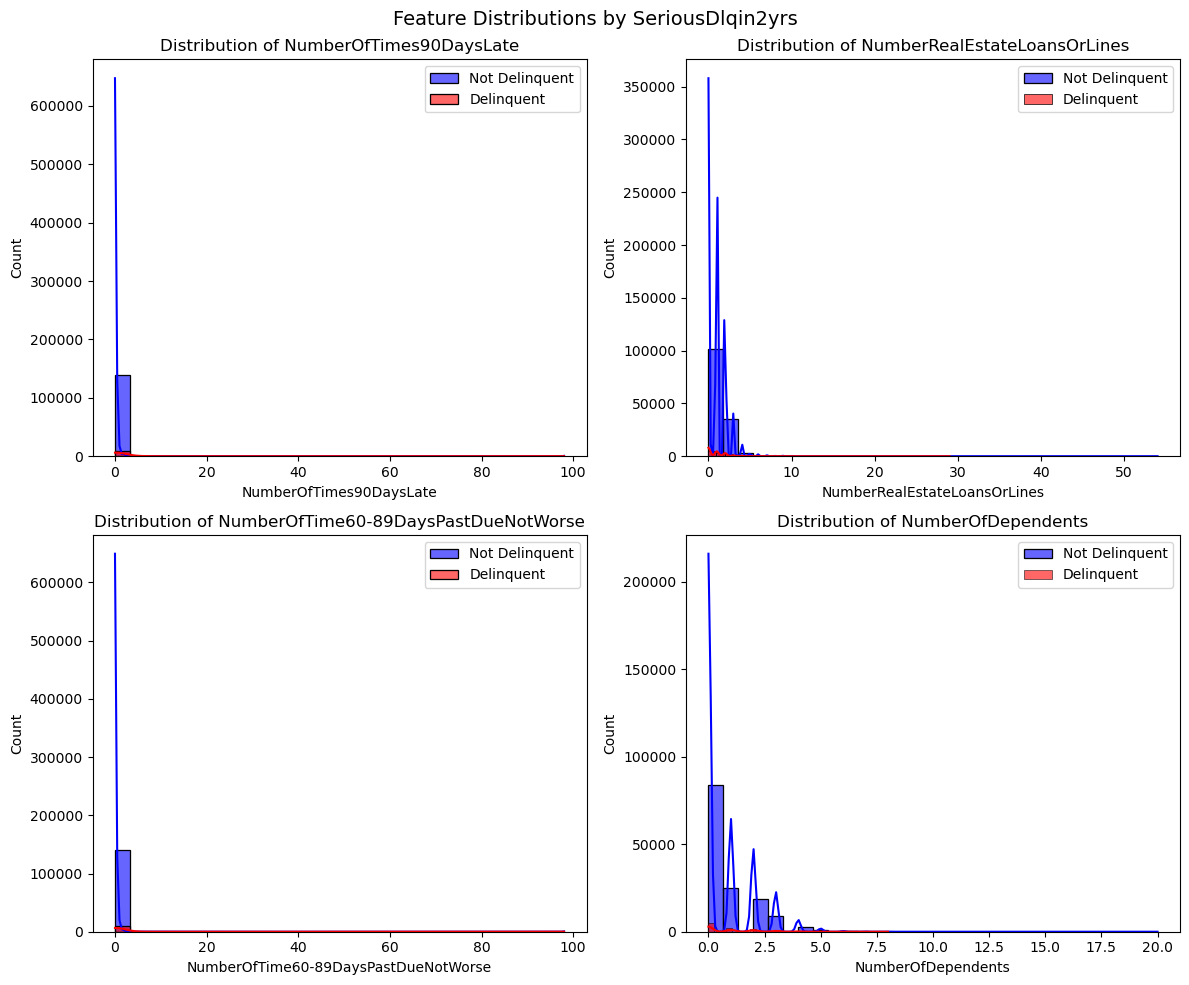

,KS Statistic,P-value
NumberOfTimes90DaysLate,0.311536,0.000000e+00
NumberRealEstateLoansOrLines,0.097949,1.386928e-78
NumberOfTime60-89DaysPastDueNotWorse,0.241747,0.000000e+00
NumberOfDependents,0.081418,2.136677e-54


In [10]:
import seaborn as sns
import scipy.stats as stats

# Separate the data by target variable
group_0 = df_filled[df_filled[target_variable] == 0]
group_1 = df_filled[df_filled[target_variable] == 1]

# Initialize figure for histograms
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.flatten()

# Plot histograms to compare distributions
for i, feature in enumerate(features_of_interest):
    sns.histplot(group_0[feature], label="Not Delinquent", kde=True, bins=30, ax=axes[i], color='blue', alpha=0.6)
    sns.histplot(group_1[feature], label="Delinquent", kde=True, bins=30, ax=axes[i], color='red', alpha=0.6)
    axes[i].set_title(f"Distribution of {feature}")
    axes[i].legend()

plt.suptitle("Feature Distributions by SeriousDlqin2yrs", fontsize=14)
plt.tight_layout()
plt.show()

# Perform statistical tests (Kolmogorov-Smirnov test) to compare distributions
ks_test_results = {}
for feature in features_of_interest:
    ks_stat, ks_p_value = stats.ks_2samp(group_0[feature], group_1[feature])
    ks_test_results[feature] = {"KS Statistic": ks_stat, "P-value": ks_p_value}

# Convert results to a DataFrame and display
ks_results_df = pd.DataFrame.from_dict(ks_test_results, orient='index')
ks_results_df


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight

# Define features and target variable
X = df_filled[features_of_interest]
y = df_filled[target_variable]

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a baseline model without reweighting
rf_baseline = RandomForestClassifier(random_state=42, n_estimators=100)
rf_baseline.fit(X_train, y_train)
y_pred_baseline = rf_baseline.predict(X_test)

# Compute metrics for the baseline model
baseline_results = {
    "Accuracy": accuracy_score(y_test, y_pred_baseline),
    "F1 Score": f1_score(y_test, y_pred_baseline),
    "ROC AUC": roc_auc_score(y_test, y_pred_baseline),
}

# Train a model with reweighted samples
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
rf_reweighted = RandomForestClassifier(random_state=42, n_estimators=100)
rf_reweighted.fit(X_train, y_train, sample_weight=sample_weights)
y_pred_reweighted = rf_reweighted.predict(X_test)

# Compute metrics for the reweighted model
reweighted_results = {
    "Accuracy": accuracy_score(y_test, y_pred_reweighted),
    "F1 Score": f1_score(y_test, y_pred_reweighted),
    "ROC AUC": roc_auc_score(y_test, y_pred_reweighted),
}

# Compare results
comparison_df = pd.DataFrame([baseline_results, reweighted_results], index=["Baseline", "Reweighted"])
comparison_df


,Accuracy,F1 Score,ROC AUC
Baseline,0.935633,0.237060,0.570777
Reweighted,0.891700,0.369249,0.697954
